**1. Take any time series of monthly or quarterly periodicity with seasonal pattern.
Clearly describe the source you use.**

I've decided to use Henry Hub Natural Gas Spot Price monthly data as my dataset for the task. I have extracted the data from the [U.S. Energy Information Administration website](https://www.eia.gov/dnav/ng/hist/rngwhhdM.htm) . I've picked the larged time span I could to capture the context of the world largest crises such as 2008 housing crisis and 2000 dot-com crash. Otherwise, the recent crisis of 2022 would be significant outlier.

In [1]:
import pandas as pd
file_path = '/content/HHNG.csv'
data = pd.read_csv(file_path)
data.set_index('Date', inplace=True)
print(data.head())

            Price
Date             
1997-01-15   3.45
1997-02-15   2.15
1997-03-15   1.89
1997-04-15   2.03
1997-05-15   2.25


**2. Visualize the time series. Try to use different plot types. Split your time series into train and test parts.**

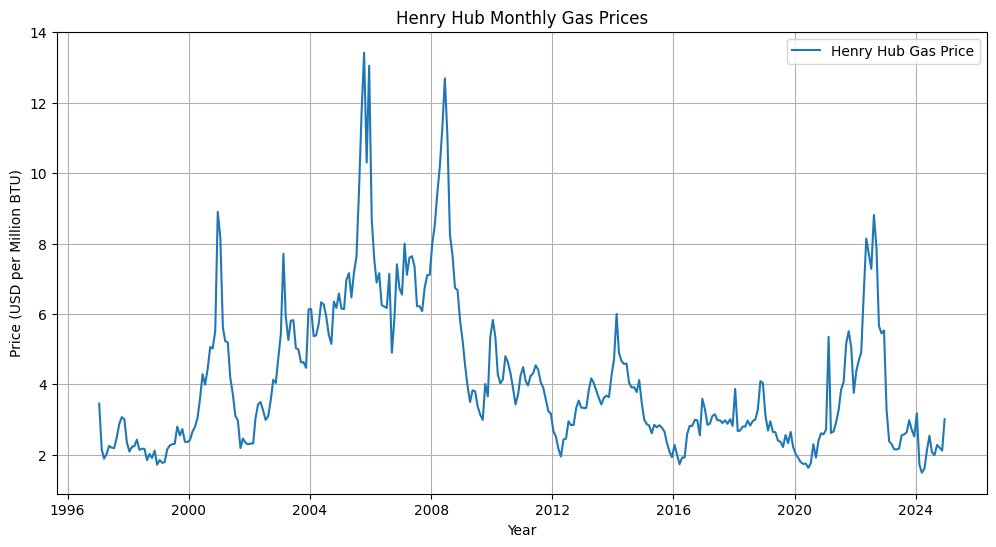

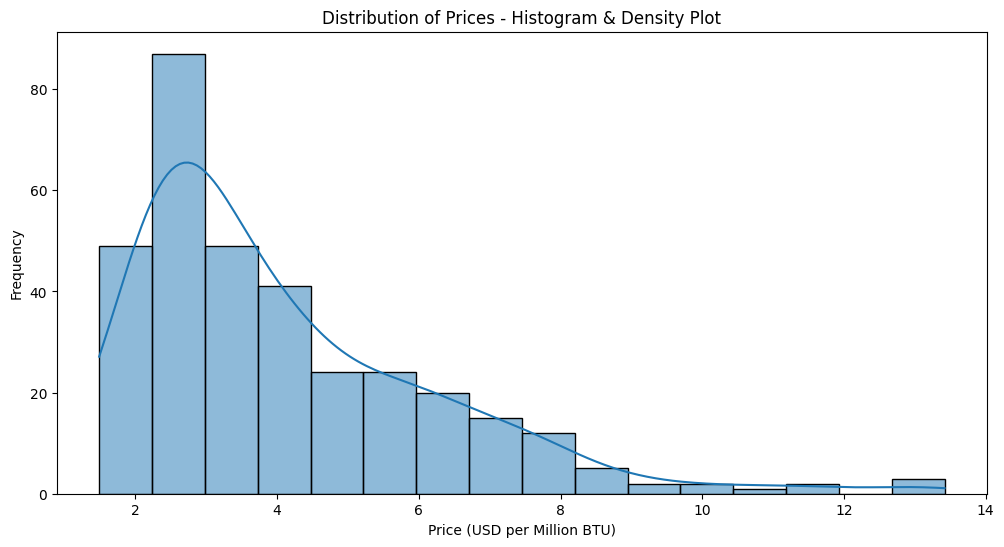

<Figure size 1200x600 with 0 Axes>

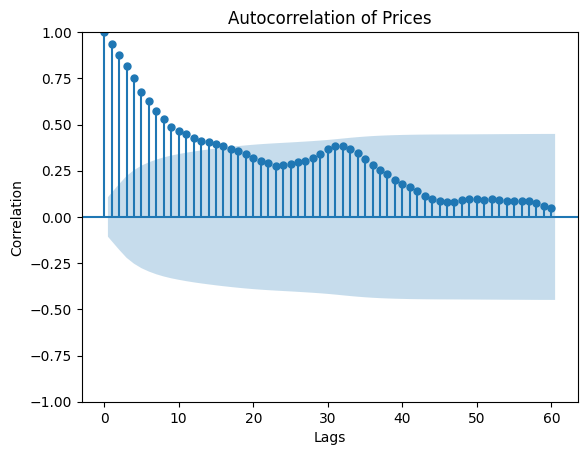

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Line
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Henry Hub Gas Price')
plt.title('Henry Hub Monthly Gas Prices')
plt.xlabel('Year')
plt.ylabel('Price (USD per Million BTU)')
plt.legend()
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data['Price'], kde=True)
plt.title('Distribution of Prices - Histogram & Density Plot')
plt.xlabel('Price (USD per Million BTU)')
plt.ylabel('Frequency')
plt.show()

# ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12, 6))
plot_acf(data['Price'], lags=60)  # I chose 60, since it stands for exaclty 5 years
plt.title('Autocorrelation of Prices')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

The line chart provides us with the fundamental price dynamics over the whole time series. If we look closely we can already see that it has seasonallity as in one way or another the chart seem to mimic itself. From the histogram we can observe that the price typically obtains values from 1 to 4, its skew represents short term hikes up to 13-14, which are likely to be due to issues in the world economical and political landscape, since they are clearly short term and the "fair" value is close to 2$. I found the autocorrelation chart interesting, as it shows that the most recent prices have the strongest impact on the next price, with effect fading away rapidly, however around lags=30 and lags 50~60, which is roughly 2.5 years and 4-5 years respectively, we can see a significant spike, which could represent the seasonal effect and suggests a cycle of 2.5 years or similar.

I have decided to do a roughly 80/20 split for testing (82/18 to be fair), because 2020 seemed to be the begining of a new cycle for the world economy, which is typically set by the crises, such as 1990s oil shock, 2000 dot-com crash and 2008 housing crises, which is proven by the dynamics on the graph.

Training set covers from 1997-01-15 00:00:00 to 2019-12-15 00:00:00
Testing set covers from 2020-01-15 00:00:00 to 2024-12-15 00:00:00


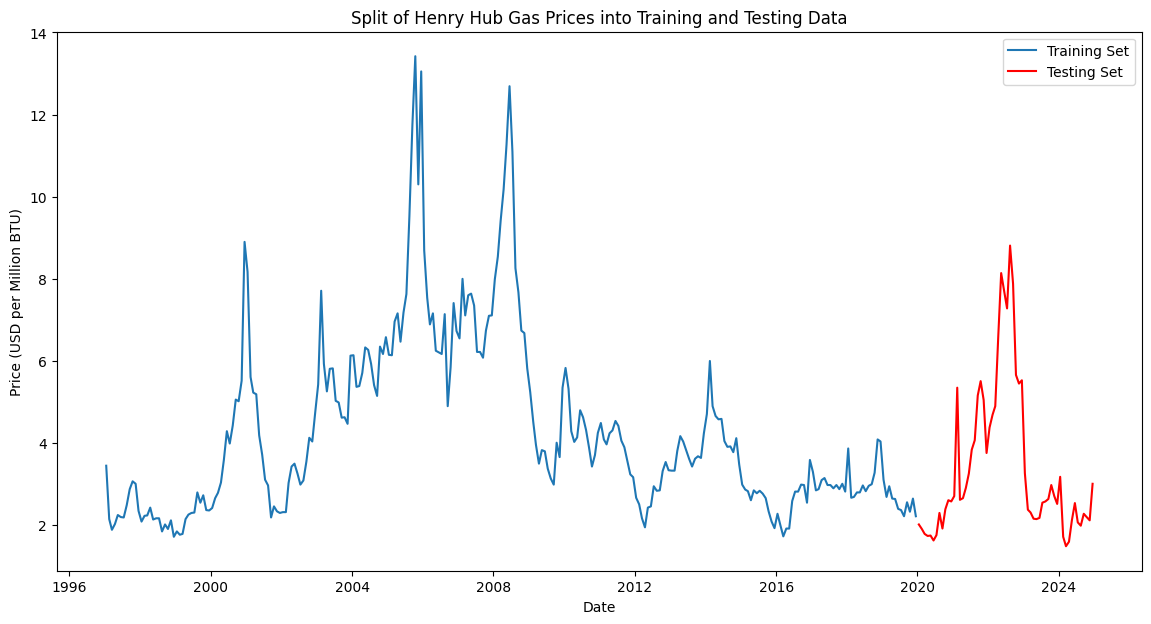

In [3]:
training_size = 276  # Number of months for training
testing_size = 60    # Number of months for testing

train = data.iloc[:training_size]
test = data.iloc[training_size:training_size + testing_size]

# Correct split?
print("Training set covers from", train.index.min(), "to", train.index.max())
print("Testing set covers from", test.index.min(), "to", test.index.max())

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Price'], label='Training Set')
plt.plot(test.index, test['Price'], label='Testing Set', color='red')
plt.title('Split of Henry Hub Gas Prices into Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Price (USD per Million BTU)')
plt.legend()
plt.show()

**3. Decompose the time series into three components (trend, seasonal part, noise) and plot them.
Here you may use ETS model or any other decomposition technique**

I thought it was reasonable to show both seasonal and ETS decomposition.

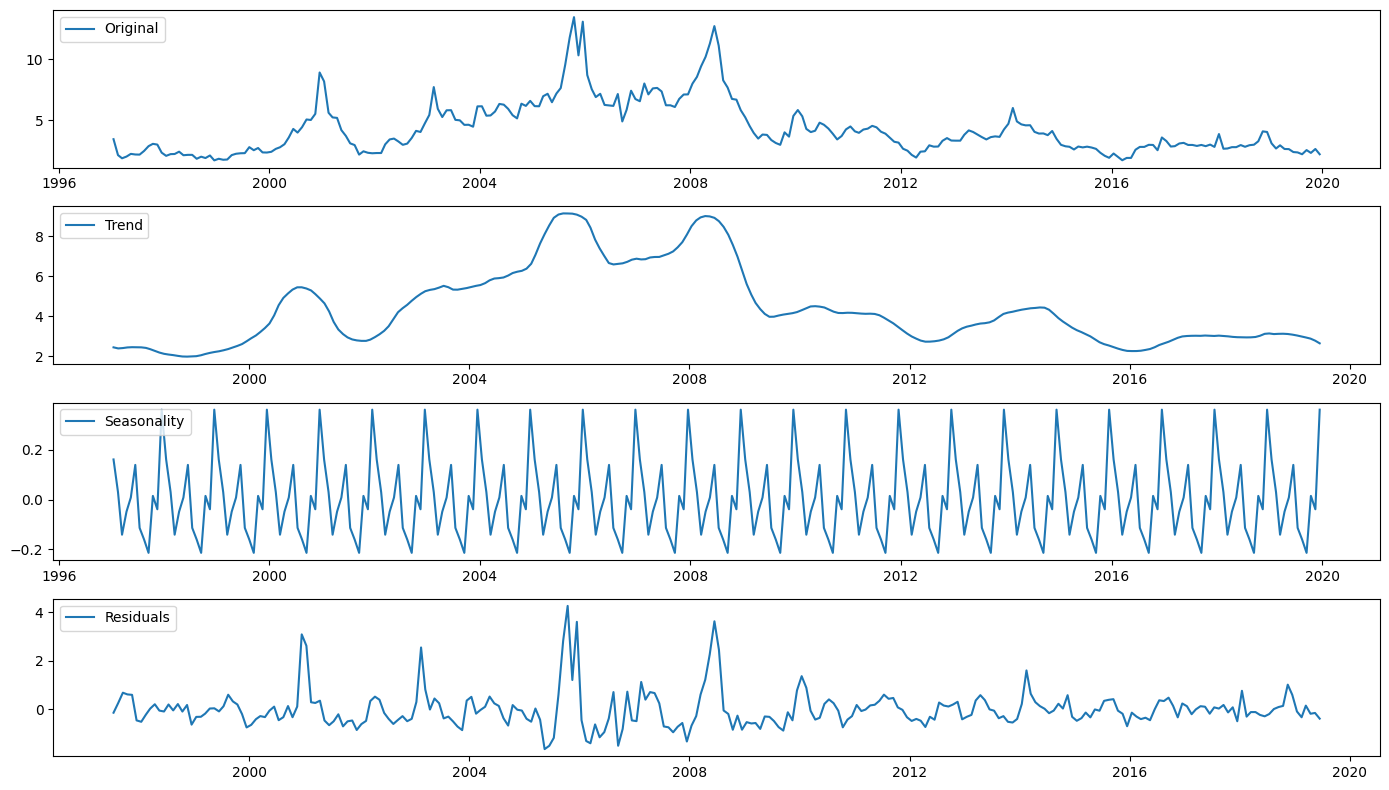

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


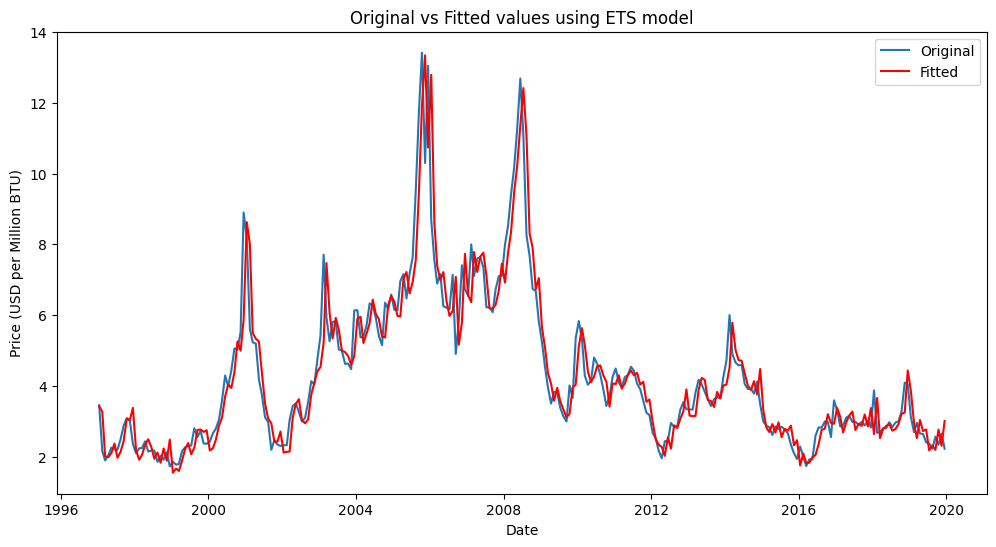

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition of the training data using an additive model
decomposition = seasonal_decompose(train['Price'], model='additive', period=12)

# Extracting the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the decomposed components
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(train['Price'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Configuring an ETS model
model = ExponentialSmoothing(train['Price'],
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12)
fitted_model = model.fit()

# Fit the model
train_predictions = fitted_model.fittedvalues

# Plotting the original series and the fitted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Price'], label='Original')
plt.plot(train.index, train_predictions, label='Fitted', color='red')
plt.title('Original vs Fitted values using ETS model')
plt.xlabel('Date')
plt.ylabel('Price (USD per Million BTU)')
plt.legend()
plt.show()

**4. Make forecasts using Random Forest or Gradient Boosting.
Clearly describe the features you create. You may use any additional predictors.**

Mean Squared Error: 0.9904467603076916


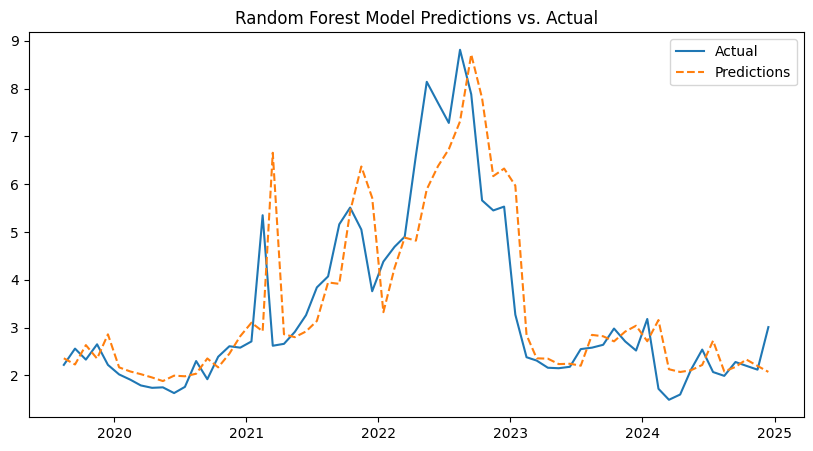

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# Generate features
data['month'] = data.index.month
data['year'] = data.index.year

# Create lag and rolling features
for lag in range(1, 13):
    data[f'lag_{lag}'] = data['Price'].shift(lag)
data['rolling_mean'] = data['Price'].rolling(window=12).mean()

# Clean NaN created by lags and rolling features
data.dropna(inplace=True)

# Features and target variable
X = data.drop('Price', axis=1)
y = data['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Predictions', linestyle='--')
plt.title('Random Forest Model Predictions vs. Actual')
plt.legend()
plt.show()